In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time
import dill

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus = tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)    # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

In [2]:
Sim, Sim_step, DerivadaEspacial, Get_weights=create_simulation(API_Numpy,burgers_equation,WENO_Z)
WENO_Z_ref=lambda u0, Δx:DerivadaEspacial(u0,Δx, FronteiraFixa)

In [3]:
np.random.seed(seed=5015324)
n=int(100000/2)
k=11
x_rep=20
pesos=np.random.uniform(size=[n,k],low=-1,high=1)
ordem=np.floor(np.random.uniform(size=[n,1],low=0,high=k))+np.asarray([range(k)])
pesos=(1-np.sum(tf.one_hot(ordem,k),axis=1))*pesos

operador_derivada=np.eye(k,k=-1)@np.diag(range(1,k+1))

In [4]:
Δx=0.01
Δx_ref=Δx/4
x_ref=np.arange(-1,1,Δx_ref)
x_ref=np.expand_dims(x_ref,0)**np.reshape(np.arange(k),[k,1])

In [5]:
k1 = np.random.uniform(0, 10, [n,1]).astype('int32')   # Amostrando uma frequência aleatória para a função seno
k2 = np.random.uniform(0, 10, [n,1]).astype('int32')   # Amostrando uma frequência aleatória para a função seno
a  = np.random.uniform(0, 1, [n,1]) # Amostrando um peso aleatória para ponderar as funções seno
b  = np.random.uniform(0, 2, [n,1]) # Amostrando um modificador de amplitude aleatório
u1 =     a * tf.math.sin(k1*pi*x_ref[1:2]) # Gerando pontos de acordo com a primeira função seno
u2 = (1-a) * tf.math.sin(k2*pi*x_ref[1:2]) # Gerando pontos de acordo com a segunda função seno

y_sin=b*(u1+u2)

#dy_sin=np.stack(dy_sin,axis=0)
#dy=np.matmul(np.matmul(pesos,operador_derivada),x+Δx/2)
y=np.matmul(x_ref.T,pesos.T).T
y=np.concatenate([y,y_sin],axis=0)

y=y/np.max(np.abs(y))

n=2*n

In [6]:
for l in range(3):
    polis=np.floor(np.random.uniform(size=[n,2],low=0,high=y.shape[0]))
    y0=y[polis[:,0].astype('int32')]
    y1=y[polis[:,1].astype('int32')]
    position=np.floor(np.random.uniform(size=[n],low=0,high=y.shape[1])).astype('int32')
    
    for i,j in zip(range(n),position):
        y0[i,(j+1):]=0
        y1[i,:j]=0
    y=y0+y1

In [7]:
indices=np.arange(0,y.shape[1],4)
y_ref=slicer(FronteiraFixa(y,API_Numpy),7,API_Numpy)[:,indices]
y=y[:,indices]

In [8]:
dy=[]
for i,y_i in enumerate(np.split(y_ref,100,axis=0)):
    print(i,end='\r')
    dy.append(WENO_Z_ref(y_i,Δx_ref)[...,3])
dy=np.concatenate(dy,axis=0)

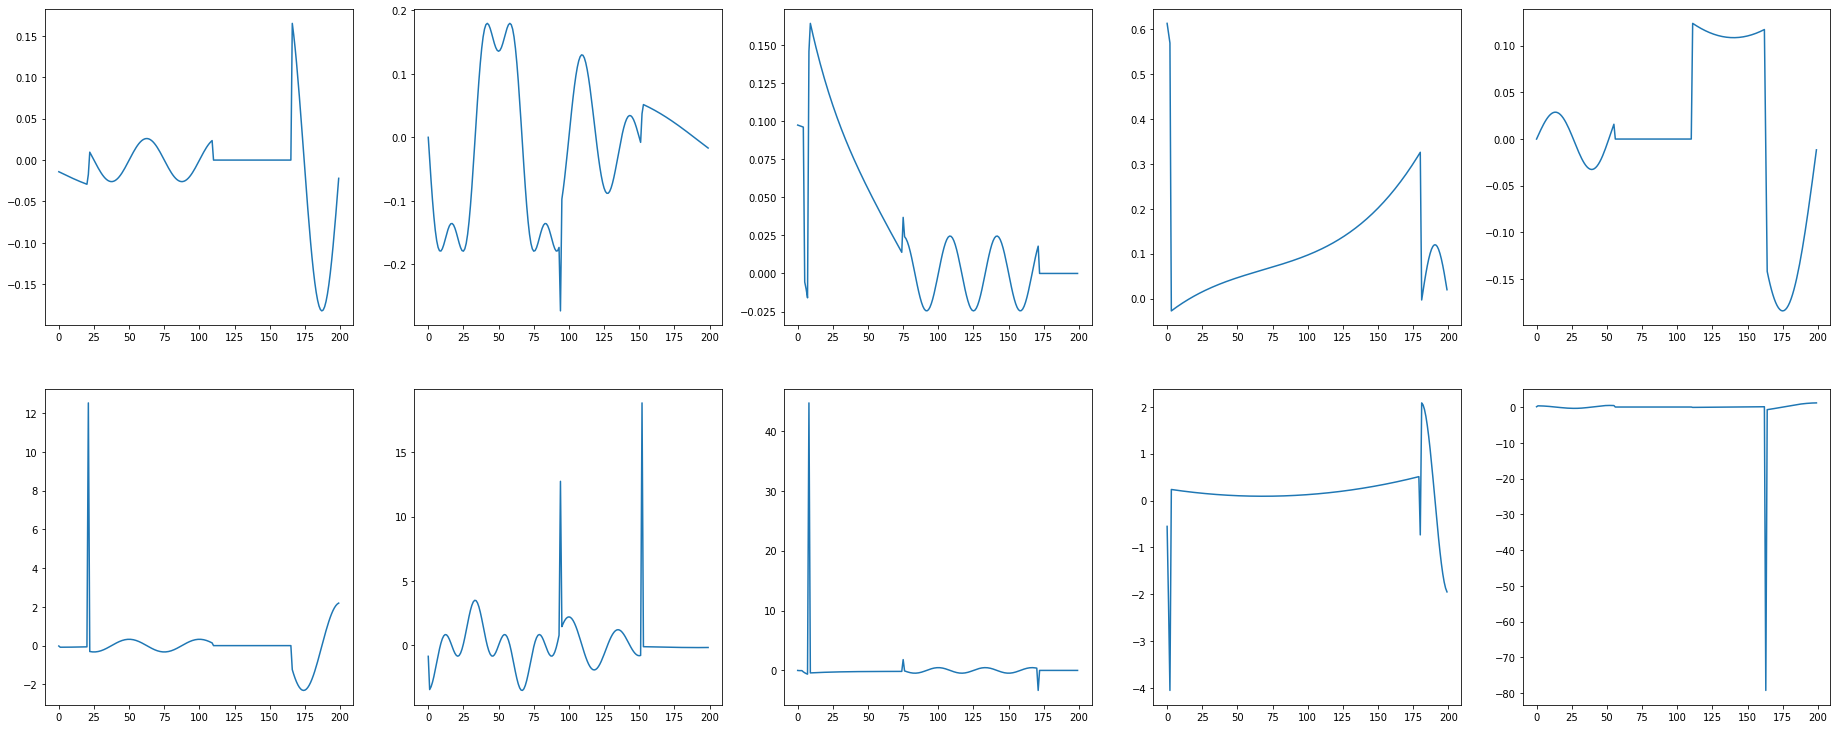

In [ ]:
index=np.floor(np.random.uniform(size=[5],low=0,high=n)).astype('int32')

plt.figure(figsize=(6.4*5,6.4*2))
for i,j in zip(range(5),index):
    plt.subplot(2, 5, i+1)
    plt.plot(y[j])
    plt.subplot(2, 5, i+6)
    plt.plot(dy[j])

In [ ]:
y=slicer(FronteiraFixa(y,API_Numpy),7,API_Numpy)
dy=np.expand_dims(dy,axis=2)

y=np.concatenate(API_Numpy.unstack(y,axis=0),axis=0)
dy=np.concatenate(API_Numpy.unstack(dy,axis=0),axis=0)

In [ ]:
with open('datasets\\Dados espaciais burgers.bkp','wb') as file:
    dill.dump([y,dy],file)